1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [16]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the training data
player_id_train = X_train.pop('player_id')

In [5]:
player_id_val = X_val.pop('player_id')

In [33]:
player_id_test = X_test.pop('player_id')

In [6]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [7]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

2. Random Forest - Feature Importance

In [9]:
# 2.1 Feature Importance Check with basic random forest model
#Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier
rf_1 = RandomForestClassifier(random_state=8,  max_features='sqrt')


rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [10]:
#Display feature importance
rf_1.feature_importances_

array([2.00406604e-03, 0.00000000e+00, 1.79110768e-05, 1.93053119e-04,
       1.38447314e-03, 1.07090852e-03, 9.44057267e-04, 6.76889484e-05,
       0.00000000e+00, 1.16605435e-04, 3.20878079e-04, 3.30745389e-04,
       0.00000000e+00, 1.84705038e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.61581515e-04,
       4.93779587e-04, 0.00000000e+00, 4.66671927e-05, 4.95339672e-04,
       2.48331474e-03, 1.74941491e-04, 3.86628811e-04, 2.96783558e-05,
       1.85799612e-03, 2.62160377e-05, 0.00000000e+00, 1.39498478e-04,
       1.26841396e-04, 2.05983409e-04, 0.00000000e+00, 9.90396931e-03,
       1.11137609e-02, 9.76558677e-03, 9.17550625e-03, 9.55920101e-03,
       7.40437494e-03, 9.60033120e-03, 9.28130563e-03, 9.02010490e-03,
       1.11191359e-02, 1.49283038e-02, 1.67891572e-02, 9.88600560e-03,
       2.23444676e-02, 1.77459049e-02, 9.20071470e-03, 8.26816786e-03,
       8.12984661e-03, 8.27205822e-03, 9.20701605e-03, 8.39414562e-03,
      

In [12]:
#Create a new dataframe "feat_imp_et_df" with the features importances and their name
feat_imp_et_df = pd.DataFrame(
    {
    'feature': X_train.columns,
     'feature_importance': rf_1.feature_importances_
     }
)

In [13]:
X_train.columns

Index(['conf_ACC', 'conf_AE', 'conf_ASun', 'conf_Amer', 'conf_B10', 'conf_B12',
       'conf_BE', 'conf_BSky', 'conf_BSth', 'conf_BW', 'conf_CAA', 'conf_CUSA',
       'conf_GWC', 'conf_Horz', 'conf_Ind', 'conf_Ivy', 'conf_MAAC',
       'conf_MAC', 'conf_MEAC', 'conf_MVC', 'conf_MWC', 'conf_NEC', 'conf_OVC',
       'conf_P10', 'conf_P12', 'conf_Pat', 'conf_SB', 'conf_SC', 'conf_SEC',
       'conf_SWAC', 'conf_Slnd', 'conf_Sum', 'conf_WAC', 'conf_WCC',
       'conf_ind', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per',
       'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM',
       'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per',
       'ftr', 'porpag', 'adjoe', 'pfr', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio', 'pick',
       'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm',
       'mp', 'o

In [17]:
#Create a bar chart showing the features importance for the random tree model
alt.Chart(feat_imp_et_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)

3. Random Forest - Modelling

In [29]:
#3.1 Import RandomForestClassifier and instantiate the model
from sklearn.ensemble import RandomForestClassifier
rf_3 = RandomForestClassifier(random_state=100,  max_features='sqrt', min_samples_split=50, max_depth = 15)


In [30]:
# 3.2 Train the model and save the predicted values
rf_3.fit(X_train, y_train)
y_train_preds_rf3 = rf_3.predict(X_train)
y_val_preds_rf3 = rf_3.predict(X_val)

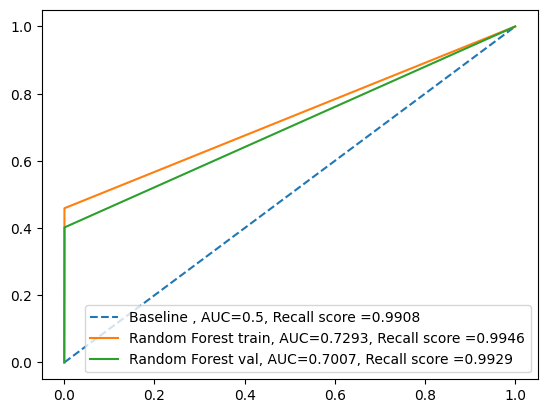

In [31]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric
from sklearn import metrics

#Baseline
# 3.1 Find the mode of the target variable and save it into a variable called y_mode
y_mode = y_train.mode()

# 3.2 Create a numpy array called y_base filled with this value of same length of y_train
y_base = np.full(y_train.shape, y_mode)

#set up plotting area
plt.figure(0).clf()

#Baseline plot
fpr, tpr, _ = metrics.roc_curve(y_train, y_base)
auc = round(metrics.roc_auc_score(y_train, y_base), 4)
recall = round(metrics.recall_score(y_train, y_base, average='weighted'),4)
plt.plot(fpr,tpr,label="Baseline , AUC="+str(auc)+", Recall score ="+str(recall),linestyle='--')

#Random Forest  - train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_preds_rf3)
auc = round(metrics.roc_auc_score(y_train, y_train_preds_rf3), 4)
recall = round(metrics.recall_score(y_train, y_train_preds_rf3, average='weighted'),4)
plt.plot(fpr,tpr,label="Random Forest train, AUC="+str(auc)+", Recall score ="+str(recall))

#Random Forest classifier  - val
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_preds_rf3)
auc = round(metrics.roc_auc_score(y_val, y_val_preds_rf3), 4)
recall = round(metrics.recall_score(y_val, y_val_preds_rf3, average='weighted'),4)
plt.plot(fpr,tpr,label="Random Forest val, AUC="+str(auc)+", Recall score ="+str(recall))

#add legend
plt.legend()

In [43]:
# 3.4 Save the probability of the test data
# Select the probability for the positive class (class 1)
y_test_prob_rf3 = y_test_prob_rf3[:, 1]


In [44]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_prob_df = pd.DataFrame(y_test_prob_rf3, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results_1 = pd.concat([player_id_test, y_test_prob_df], axis=1)

In [45]:
Results_1

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.000000
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.000000
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.001179
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.000000
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.001250
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.000333
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.000000
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.010000
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.000000


In [ ]:
3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results_1).to_csv('../data/processed/y_test_prob_rf3.csv', index=False)